# Feet to Text: 
## a tap dance decoder

Thirty years ago, I began my love affair with tap dance. In addition to participating in training and watching live performances, I regularly watch uploaded youtube videos to see the latest choreography from some of my idols. Often I'd like to learn the pieces I've seen online, but unfortunately have to wait until they host master classes on this continent. That's because it is very difficult to decipher their fancy, fast footwork based solely on audio and video. Many steps sound alike. Add in the extra dimension of different quality shoes, floors, and microphones, and it's near impossible to recreate their steps at full speed ... <br/><br/> ... for humans. But could a machine learn to decipher steps better than even a trained ear?<br/> That is exactly what I want to find out.

In [83]:
from IPython.display import Image
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from pydub import AudioSegment
import torch
from pathlib import Path
import torch.nn.functional as F
import time



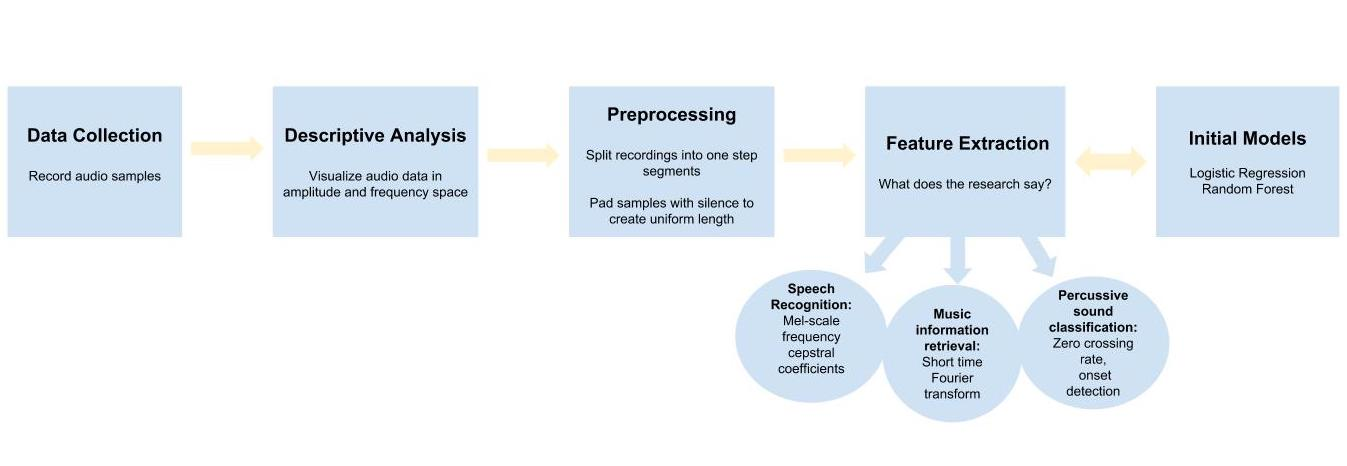

In [7]:
Image('../../../Source/Data/MLWorkflowpt1.jpg')

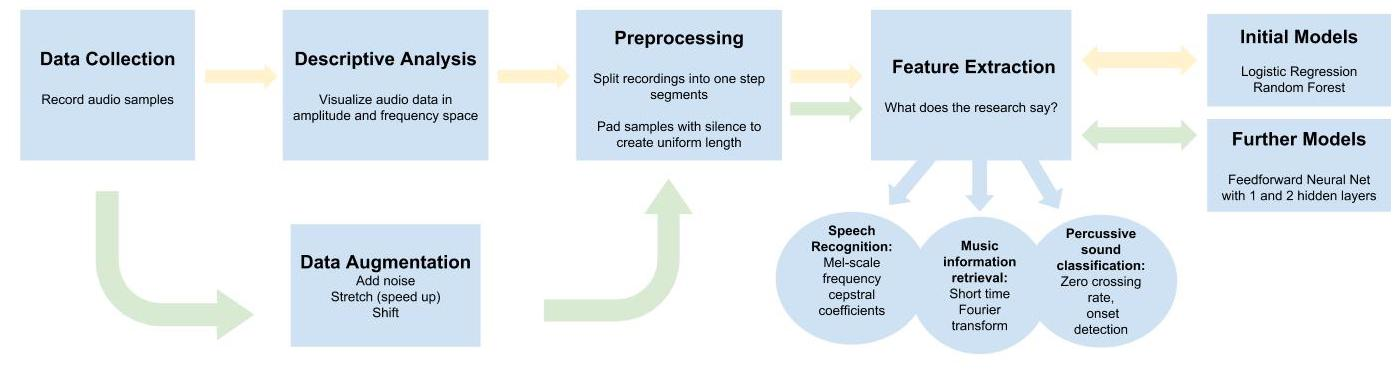

In [8]:
Image('../../../Source/Data/MLWorkflowpt2.jpg')

-----

## Data Collection


While it might seem time consuming to actually listen to all of these clips, it isn't all that crazy considering each root file is no more than 60 seconds long in total. I decided that the time trade-off is worth it to have clean, true data.


**Step 1:**
- Record samples from volunteers, with different shoes, at different speeds
- Export all recordings as wav files
**Step 2: **
- Check dBFS for all files
- Use results in next step
Step 3:
- Cut files into chunks (split on silence) and export
- Audibly check files with pydub
- Sort out clips without 2 sounds
- Visually check files with librosa <br/>

Before: 


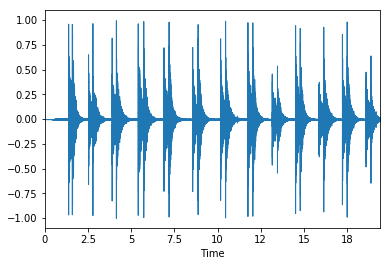

In [14]:
print('Before: ')
Image('../../../Source/Data/Manyshuffles.png')

After: 


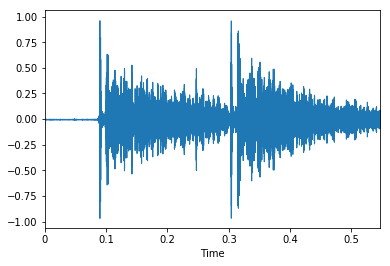

In [15]:
print('After: ')
Image('../../../Source/Data/Oneshuffle.png')

-----

## Descriptive Analysis
Visualizing the data, and jumping in the deep-end of digital signal processing

**How does this work?** <br/> This gets ***complicated.*** Let's break it down:
1. Start with signal data (Amplitude vs. Time)
2. Cut it up into discrete chunks of time
3. Apply a window function (Hann function) 
4. Take an N-point (n_fft=256) fast Fourier transformation (FFT)
5. Power spectrum = ((absolute value of FFT values)^2)/n_fft 
6. Calculate triangular filterbanks to transfrom Hz scale to mel scale
7. Get log spectrum
8. Apply Discrete Cosine Transform to decorrelate filterbank and yield a compressed representation of the filterbanks
9. Keep the first 20 cepstral coefficients
10. I believe one more round of mean normalization is included.
 <br/><br/>Of course, this all happens in one nice step in librosa, but it's good to have a little background in the process.


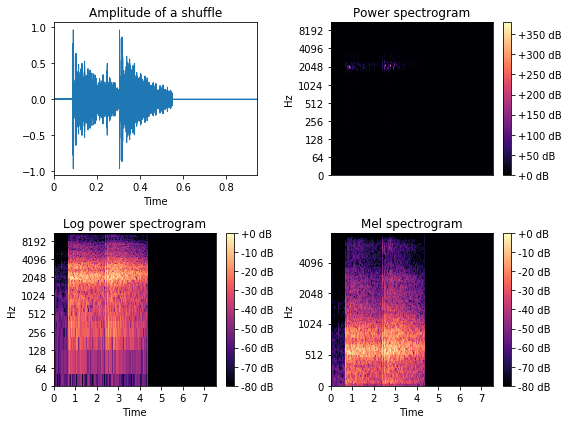

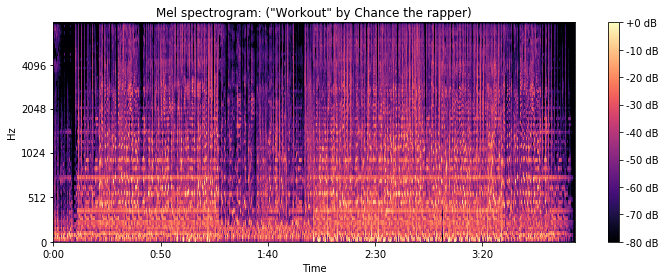

In [25]:
y, sr = librosa.load('../../../Source/Clean_train_clips/Train_augment_pad/Shuffle/1/1_.wav')
D = np.abs(librosa.stft(y, n_fft=256))

# Wave plot
plt.figure(figsize=(8,6))
plt.subplot(221)
librosa.display.waveplot(y, sr=sr)
plt.title('Amplitude of a shuffle')


# Power spectrogram where D = |STFT(y)|
plt.subplot(222)
librosa.display.specshow(D**2, sr=sr, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')

# Log power with power_to_db
plt.subplot(223)
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),sr=sr, y_axis='log', x_axis='time')
plt.title('Log power spectrogram')
plt.colorbar(format='%+2.0f dB')

# Mel spectrogram 
plt.subplot(224)
librosa.display.specshow(librosa.power_to_db(D**2,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram');
plt.tight_layout()



y, sr = librosa.load('../../../workout.wav')
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)


plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram: ("Workout" by Chance the rapper)')
plt.tight_layout()

Linear-frequency power spectrogram for two different steps


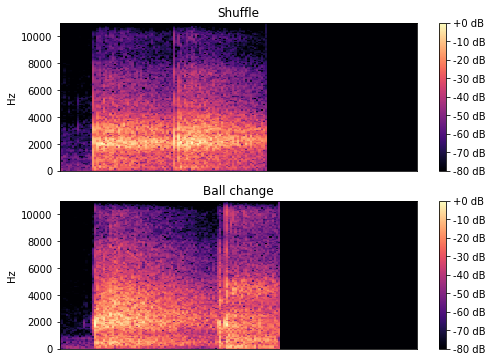

In [28]:
print('Linear-frequency power spectrogram for two different steps')
Image('../../../Source/Data/Twosteps.png')

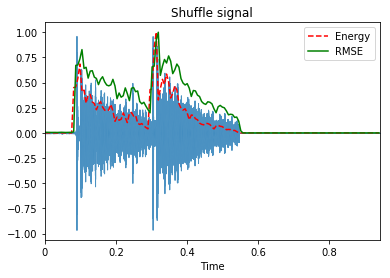

In [30]:
Image('../../../Source/Data/Energyplots.png')

### Features:
1. Mel-frequency cepstral coefficients (MFCCs) : 20 coefficients
2. Zero crossing rate (ZCR) : 163 values
3. Energy : 163 values
4. Root mean square energy (RMSE) : 163 values
5. Tempo (BPM) : 1 value

Data cleaning, feature extraction and labelling were carried out efficiently with Path and a loop for each feature.

In [112]:
tap_df = pd.read_csv('../../../Source/Data/all_data_pad_mfcc_zcr_energy_rmse_bpm.csv')
tap_df.head()

,Path,Labels,0,1,2,3,4,5,6,7,...,500,501,502,503,504,505,506,507,508,BPM
0,../../../Source/Clean_train_clips/All_data_pad...,1,-316.899433,40.496876,-47.606103,20.414424,-13.223124,9.532101,-9.091608,-0.184608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.768029
1,../../../Source/Clean_train_clips/All_data_pad...,1,-382.872937,51.379340,-46.647768,19.897312,-3.929729,2.681134,-9.399345,-1.389285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.332031
2,../../../Source/Clean_train_clips/All_data_pad...,1,-371.174863,50.103908,-71.744771,21.426257,-7.118995,-4.108719,-12.560796,-0.070634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.999081
3,../../../Source/Clean_train_clips/All_data_pad...,1,-319.385528,83.077064,-74.035784,16.116328,-8.312489,1.627171,-18.326527,-2.684849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.999081
4,../../../Source/Clean_train_clips/All_data_pad...,0,-405.937876,35.606141,-31.218399,13.855576,-16.178129,3.175495,-8.401305,-5.367274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161.499023


-----

### Initial Models with sklearn:
Quick and dirty tests on the complete (510) features
* Logistic Regression
* Random Forest

In [113]:
sklearn_results = pd.read_csv('../../../Source/Data/results_sklearn_all_data_all_features.csv')

In [114]:
sklearn_results.head()

,True,Predict_lr,Prob_0_lr,Predict_rf,Prob_0_rf
0,0,0,0.999998,0,0.8
1,1,1,0.001497,1,0.1
2,1,0,1.000000,0,0.8
3,0,0,0.999998,0,1.0
4,0,0,1.000000,0,0.8


In [115]:
print('LogReg Accuracy: ' + str(accuracy_score(sklearn_results['True'],sklearn_results['Predict_lr'] )))
print('Random Forest Accuracy: ' + str(accuracy_score(sklearn_results['True'],sklearn_results['Predict_rf'] )))

LogReg Accuracy: 0.8157894736842105
Random Forest Accuracy: 0.8508771929824561


In [116]:
print('LogReg mistakes')
sklearn_results.loc[~(sklearn_results['True'] == sklearn_results['Predict_lr'])]

LogReg mistakes


,True,Predict_lr,Prob_0_lr,Predict_rf,Prob_0_rf
2,1,0,1.000000,0,0.8
11,0,1,0.001525,0,0.5
15,0,1,0.195754,1,0.3
16,1,0,0.743812,1,0.2
20,1,0,0.878937,1,0.4
23,1,0,0.969439,1,0.3
25,1,0,0.999577,1,0.0
26,0,1,0.000298,0,0.6
29,0,1,0.000714,1,0.3
36,0,1,0.166134,1,0.2


In [117]:
print('Random Forest mistakes')
sklearn_results.loc[~(sklearn_results['True'] == sklearn_results['Predict_rf'])]

Random Forest mistakes


,True,Predict_lr,Prob_0_lr,Predict_rf,Prob_0_rf
2,1,0,1.000000e+00,0,0.8
15,0,1,1.957540e-01,1,0.3
29,0,1,7.143472e-04,1,0.3
31,1,1,5.176091e-07,0,0.6
36,0,1,1.661337e-01,1,0.2
37,1,1,7.552233e-03,0,0.8
38,1,1,1.332179e-04,0,0.6
45,0,0,9.996257e-01,1,0.3
47,0,0,9.999981e-01,1,0.4
57,1,1,3.919344e-02,0,0.5


Based on cross validation scores, it was shown that the generalized linear model (LogReg) outperforms the nonlinear model (Random Forest), which appeared to be overfitting the data. <br/> By reducing the max depth to avoid overfitting, and by increasing the number of trees, the Random Forest model delivered improved accuracy results (Accuracy score: 0.90351) as well as better cross validation scores compared to logistic regression. (See MVP_audio_preaugmentation)

---

### Data Augmentation
What can be done about a limited (342) data set? <br/> 
We can multiply the training set (by three) with the help of transformations, like adding noise, stretching, and shifting.<br/>
Data for validation and test sets were set aside prior to augmentation. These observations were not transformed.

In [118]:
sklearn_results2 = pd.read_csv('../../../Source/Data/results_sklearn_validatetest_all_augment.csv')
print('LogReg Accuracy: ' + str(accuracy_score(sklearn_results2['True'],sklearn_results2['Predict_lr'] )))
print('Random Forest Accuracy: ' + str(accuracy_score(sklearn_results2['True'],sklearn_results2['Predict_rf'] )))

LogReg Accuracy: 0.8157894736842105
Random Forest Accuracy: 0.8947368421052632


Adding extra data brings a slight improvement to these models. In addition, there's also more data with which to train an artificial neural network.

---

### Neural Network
Feedforward neural networks with 1- and 2-hidden layers with various amounts of nodes. <br/>
Additionally, models were trained on different feature combinations to compare their performance.

In [119]:
t1 = pd.read_csv('../src/predict/predictions/true_two_hidden_test_mfcc_bpm.csv', names=['True'])
r1 = pd.read_csv('../src/predict/predictions/two_hidden_test_mfcc_bpm.csv', names=['Pred'])

t2 = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_bpm_128.csv', names=['True'])
r2 = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_bpm_128.csv', names=['Pred'])

t3 = pd.read_csv('../src/predict/predictions/true_two_hidden_test_mfcc.csv', names=['True'])
r3 = pd.read_csv('../src/predict/predictions/two_hidden_test_mfcc.csv', names=['Pred'])

t4 = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_128.csv', names=['True'])
r4 = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_128.csv', names=['Pred'])

t5 = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_zcr_energy_rmse_bpm_256.csv', names=['True'])
r5 = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_zcr_energy_rmse_bpm_256.csv', names=['Pred'])

t6 = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_zcr_energy_rmse_bpm_128.csv', names=['True'])
r6 = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_zcr_energy_rmse_bpm_128.csv', names=['Pred'])

t7 = pd.read_csv('../src/predict/predictions/true_two_hidden_test_mfcc_zcr_energy_rmse_bpm.csv', names=['True'])
r7 = pd.read_csv('../src/predict/predictions/two_hidden_test_mfcc_zcr_energy_rmse_bpm.csv', names=['Pred'])

t8 = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_zcr_energy_rmse_bpm.csv', names=['True'])
r8 = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_zcr_energy_rmse_bpm.csv', names=['Pred'])

In [120]:
results1 = pd.concat([r1, t1], axis = 1)
results2 = pd.concat([r2, t2], axis = 1)
results3 = pd.concat([r3, t3], axis = 1)
results4 = pd.concat([r4, t4], axis = 1)
results5 = pd.concat([r5, t5], axis = 1)
results6 = pd.concat([r6, t6], axis = 1)
results7 = pd.concat([r7, t7], axis = 1)
results8 = pd.concat([r8, t8], axis = 1)

In [121]:
df_list = [results1, results2, results3, results4, results5, results6, results7, results8]
acc_list, pre_list, rec_list, f1_list = [], [], [], []
for df in df_list:
    acc_list.append(accuracy_score(y_true=df['True'], y_pred=df['Pred']))
    pre_list.append(precision_score(y_true=df['True'], y_pred=df['Pred']))
    rec_list.append(recall_score(y_true=df['True'], y_pred=df['Pred']))
    f1_list.append(f1_score(y_true=df['True'], y_pred=df['Pred']))

In [143]:
torch_results = pd.DataFrame(acc_list, columns=['Accuracy'])
torch_results.index = [ 'H2_mfcc_bpm',  # H2 128 and 64  for all H2 examples here
                        'H1_mfcc_bpm_128',
                        'H2_mfcc',
                        'H1_mfcc_128',
                        'H1_all_256',
                        'H1_all_128',
                        'H2_all',
                        'H1_all'] # Is this the same as H1_all_128? It has the same results
torch_results['Precision score'] = pre_list
torch_results['Recall score'] = rec_list
torch_results['F1 score'] = f1_list

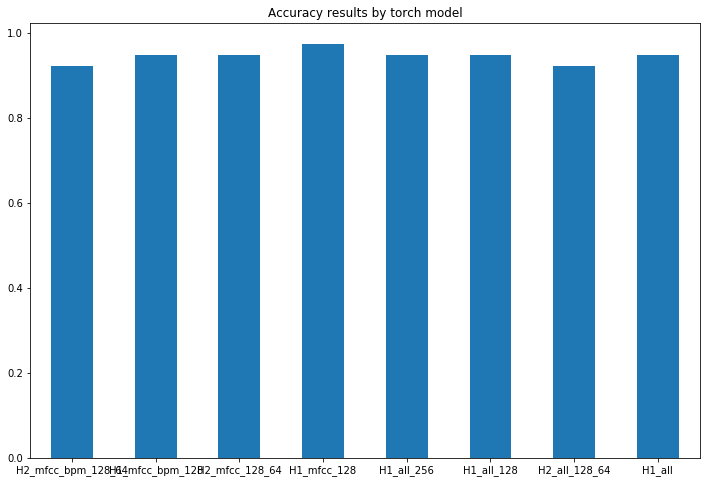

In [144]:
ax = torch_results[['Accuracy']].plot.bar(legend=False,  figsize=(12,8), rot=0)
ax.set_title('Accuracy results by torch model');

In [124]:
torch_results

,Accuracy,Precision score,Recall score,F1 score
H2_mfcc_bpm,0.921053,0.913043,0.954545,0.933333
H1_mfcc_bpm_128,0.947368,0.916667,1.000000,0.956522
H2_mfcc,0.947368,0.916667,1.000000,0.956522
H1_mfcc_128,0.973684,0.956522,1.000000,0.977778
H1_all_256,0.947368,0.954545,0.954545,0.954545
H1_all_128,0.947368,0.916667,1.000000,0.956522
H2_all,0.921053,0.952381,0.909091,0.930233
H1_all,0.947368,0.916667,1.000000,0.956522


In [125]:
df_list = [results1, results2, results3, results4, results5, results6, results7, results8]
model_names = [ 'H2_mfcc_bpm','H1_mfcc_bpm_128','H2_mfcc','H1_mfcc_128','H1_all_256','H1_all_128','H2_all','H1_all']
i = 0
for df in df_list:
    print(model_names[i])
    print(confusion_matrix(y_true=df['True'], y_pred=df['Pred']))
    print('Precision score: ' + str(precision_score(y_true=df['True'], y_pred=df['Pred'])))
    print('Recall score: ' + str(recall_score(y_true=df['True'], y_pred=df['Pred'])))
    print('F1 score: ' + str(f1_score(y_true=df['True'], y_pred=df['Pred'])))
    print()
    i += 1

H2_mfcc_bpm
[[14  2]
 [ 1 21]]
Precision score: 0.9130434782608695
Recall score: 0.9545454545454546
F1 score: 0.9333333333333332

H1_mfcc_bpm_128
[[14  2]
 [ 0 22]]
Precision score: 0.9166666666666666
Recall score: 1.0
F1 score: 0.9565217391304348

H2_mfcc
[[14  2]
 [ 0 22]]
Precision score: 0.9166666666666666
Recall score: 1.0
F1 score: 0.9565217391304348

H1_mfcc_128
[[15  1]
 [ 0 22]]
Precision score: 0.9565217391304348
Recall score: 1.0
F1 score: 0.9777777777777777

H1_all_256
[[15  1]
 [ 1 21]]
Precision score: 0.9545454545454546
Recall score: 0.9545454545454546
F1 score: 0.9545454545454546

H1_all_128
[[14  2]
 [ 0 22]]
Precision score: 0.9166666666666666
Recall score: 1.0
F1 score: 0.9565217391304348

H2_all
[[15  1]
 [ 2 20]]
Precision score: 0.9523809523809523
Recall score: 0.9090909090909091
F1 score: 0.9302325581395349

H1_all
[[14  2]
 [ 0 22]]
Precision score: 0.9166666666666666
Recall score: 1.0
F1 score: 0.9565217391304348



**How did the best model (H1_mfcc_128) hold up with the test set?**

In [126]:
best_t = pd.read_csv('../src/predict/predictions/true_one_hidden_test_mfcc_128_testset.csv', names=['True'])
best_r = pd.read_csv('../src/predict/predictions/one_hidden_test_mfcc_128_testset.csv', names=['Pred'])
best_results = pd.concat([best_r, best_t], axis = 1)
print(confusion_matrix(y_true=best_results['True'], y_pred=best_results['Pred']))
print('Precision score: ' + str(precision_score(y_true=best_results['True'], y_pred=best_results['Pred'])))
print('Recall score: ' + str(recall_score(y_true=best_results['True'], y_pred=best_results['Pred'])))
print('F1 score: ' + str(f1_score(y_true=best_results['True'], y_pred=best_results['Pred'])))

[[29  2]
 [ 1 44]]
Precision score: 0.9565217391304348
Recall score: 0.9777777777777777
F1 score: 0.967032967032967


**Not too bad!**

---

## From start to finish:
Complete process with option to try out various model and feature combinations

### Select test tap sound

In [127]:
# Prepared, reserved test clip recorded same as train
#clip = '../../../Source/Clean_train_clips/Test_pad/Shuffle/1/15.wav'

# Audio extracted from youtube
clip = '../../../Source/Shuffle/2/1.wav'
#clip= '../../../Source/test_shuffle.wav'

clip_path = Path(clip)

In [128]:
# Play sound
AudioSegment.from_wav(clip)

### Data processing and feature extraction

In [139]:
# Parameters (determined in training and validation)

clip_length = 20772
n_mfcc = 20
frame_length = 256
hop_length = 128

In [140]:
# Feature generating functions

class Features:
    def __init__(self, samples, sample_rate, clip_length, n_mfcc, frame_length, hop_length):
        self.samples = samples
        self.sample_rate = sample_rate
        self.clip_length = clip_length
        self.n_mfcc = n_mfcc
        self.frame_length = frame_length
        self.hop_length = hop_length

    def get_features_mfcc(self):
        mfccs = np.mean(librosa.feature.mfcc(y=self.samples,
                                             sr=self.sample_rate,
                                             n_mfcc=self.n_mfcc).T, axis=0)
        return mfccs.tolist()

    def get_features_zcr(self):
        zcr = librosa.feature.zero_crossing_rate(self.samples,
                                                 frame_length=self.frame_length,
                                                 hop_length=self.hop_length)
        return zcr.T.flatten().tolist()

    def get_features_energy(self):
        energy = np.array([sum(abs(self.samples[i:i + self.frame_length] ** 2))
                           for i in range(0, len(self.samples), self.hop_length)])
        return energy.tolist()

    def get_features_rmse(self):
        rmse = librosa.feature.rmse(self.samples,
                                    frame_length=self.frame_length,
                                    hop_length=self.hop_length,
                                    center=True)
        return rmse[0].tolist()

    def get_features_bpm(self):
        onset_env = librosa.onset.onset_strength(self.samples,
                                                 sr=self.sample_rate)  # Assumes static tempo, dynamic:aggregate=None
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=self.sample_rate)
        return tempo.tolist()

    def get_feature_array(self, feature_list):
        feature_dict = {}
        features = []
        for i in feature_list:
            if i == 'mfcc':
                feature_dict[i] = self.get_features_mfcc()
                features += (feature_dict.get('mfcc'))
            if i == 'zcr':
                feature_dict[i] = self.get_features_zcr()
                features += (feature_dict.get('zcr'))
            if i == 'energy':
                feature_dict[i] = self.get_features_energy()
                features += (feature_dict.get('energy'))
            if i == 'rmse':
                feature_dict[i] = self.get_features_rmse()
                features += (feature_dict.get('rmse'))
            if i == 'bpm':
                feature_dict[i] = self.get_features_bpm()
                features += (feature_dict.get('bpm'))
        return np.array(features)


# Feature utility functions

def get_label(path):
    path = Path(path)
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0


def playback(path):
    audio = (AudioSegment.from_wav(path))
    return audio


def resize_signal(path, length):
    samples, sample_rate = librosa.load(path)
    if len(samples) < length:
        y = np.pad(samples, (0, length - len(samples)), 'constant')
    elif len(samples) > length:
        y = samples[:length]
    else:
        y = samples
    return y, sample_rate


### Select features and model

In [141]:
# Features

feature_list = ['mfcc']

# Model

model = '../src/train/trained_models/one_hidden_mfcc_128.pt'

#model = '../src/train/trained_models/one_hidden_mfcc_energy_bpm_12.pt'
#model = ('../src/train/trained_models/one_hidden_mfcc_zcr_energy_rmse_bpm.pt')
#model = ('../src/train/trained_models/one_hidden_mfcc_zcr_energy_rmse_bpm_128.pt')
#model = ('../src/train/trained_models/one_hidden_mfcc_zcr_energy_rmse_bpm_256.pt')
#model = ('../src/train/trained_models/two_hidden_mfcc_zcr_energy_rmse_bpm.pt')

#model = ('../src/train/trained_models/one_hidden_mfcc_128.pt')
#model = ('../src/train/trained_models/two_hidden_mfcc.pt')
#model = ('../src/train/trained_models/one_hidden_mfcc_bpm_128.pt')
#model = ('../src/train/trained_models/two_hidden_mfcc_bpm.pt')

### Run and predict

In [142]:
# Start the clock
start = time.time()

# Reshape test data
samples, sample_rate = resize_signal(path=clip, length=clip_length)

# Get feature input data
test_features = Features(samples=samples,
                                 sample_rate=sample_rate,
                                 clip_length=clip_length,
                                 n_mfcc=n_mfcc,
                                 frame_length=frame_length,
                                 hop_length=hop_length)

inputs = (test_features.get_feature_array(feature_list=feature_list))

# Load and Predict
dtype = torch.float
device = torch.device('cpu')

inputs = torch.tensor(inputs, device=device, dtype=dtype)

# Load model
model = torch.load(model)

outputs = model(inputs)

y_pred = (torch.argmax(outputs.data).numpy())

true = get_label(clip)

print("What's that tap?")
print()
if y_pred == 1:
    print('Predicted: Shuffle')
elif y_pred == 0:
    print('Predicted: Ball change')
print()
if true == 1:
    print('It was a Shuffle.')
elif true == 0:
    print('It was a Ball change.')

# End the clock and print time
end = time.time()
print()
print(f'Time elapsed: {end - start}s.')


What's that tap?

Predicted: Shuffle

It was a Shuffle.

Time elapsed: 0.07843732833862305s.


---

## Further options

* Continue to grow data set by saving inputs and user labels from recording app
* Classification of more steps (flaps, riffs, wings, pullbacks)
* Fit tap choreography (recording or sequence of recordings) to music (from opensource or personal library) based on length and tempo of recording

## Questions?